In [1]:
from models.api_models import *
from tqdm import tqdm
import time
import joblib
from models.feature_extractor import FeatureExtractor
from models.win_rate_models import WinRateSciKitModel
from models.mcts_draft import AllPickDraft, CaptainsModeDraft, getOrderedMoves
from mcts import mcts
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
EVALUATE_PICKE_PATH = 'input/pro_pb.joblib' 

In [3]:
feature_extractor = joblib.load('input/feature_extractor.joblib')
linear_svc = joblib.load('input/linear_svc.joblib')
win_rate_model = WinRateSciKitModel(feature_extractor, linear_svc)

In [4]:
picks_bans_list = joblib.load(EVALUATE_PICKE_PATH)

In [5]:
def to_initial_state(pb_list, wr_model, n_first=3):
    bans = []
    radiant_picks = []
    dire_picks = []
    pb_list, radiant_win = pb_list
    for pb in pb_list:
        if not pb.is_pick:
            bans.append(pb.hero_id)
        else:
            if pb.team == 1:
                radiant_picks.append(pb.hero_id)
            else:
                dire_picks.append(pb.hero_id)
    state = AllPickDraft(wr_model, bans=bans, radiant_picks=set(radiant_picks[:n_first]), dire_picks=set(dire_picks[:n_first]))
    return state, radiant_picks[n_first:], dire_picks[n_first:], radiant_win

In [6]:
pick_bans_states = [to_initial_state(picks_bans, win_rate_model) for picks_bans in picks_bans_list]

In [7]:
results = []
for state, rlp, dlp, radiant_win in tqdm(pick_bans_states):

    if radiant_win:
        # radiant
        state_r = deepcopy(state)
        state_r.is_radiant_player = True
        mcts_object = mcts(timeLimit=5_000, explorationConstant=2*math.sqrt(2))
        mcts_object.search(state_r)
        top_n = getOrderedMoves(mcts_object, 130)
        results.append((top_n, rlp))
    else:
        # dire
        state_d = deepcopy(state)
        state_d.is_radiant_player = False
        mcts_object = mcts(timeLimit=5_000, explorationConstant=2*math.sqrt(2))
        mcts_object.search(state_d)
        top_n = getOrderedMoves(mcts_object, 130)
        results.append((top_n, dlp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [08:15<00:00,  5.00s/it]


In [8]:
ranks = []
for propose, query in results:
    ranks.append(propose.index(query[0])+1)
    ranks.append(propose.index(query[1])+1)

Text(0, 0.5, 'Ilość')

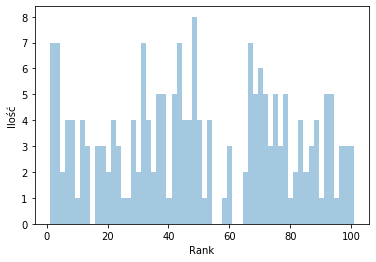

In [9]:
sns.distplot(ranks, bins=60, kde=False)
plt.xlabel('Rank')
plt.ylabel('Ilość')

In [10]:
pick_bans_states = [to_initial_state(picks_bans, win_rate_model, 4) for picks_bans in picks_bans_list]

In [11]:
results = []
for state, rlp, dlp, radiant_win in tqdm(pick_bans_states):

    if radiant_win:
        # radiant
        state_r = deepcopy(state)
        state_r.is_radiant_player = True
        mcts_object = mcts(timeLimit=2_000, explorationConstant=math.sqrt(2))
        mcts_object.search(state_r)
        top_n = getOrderedMoves(mcts_object, 130)
        results.append((top_n, rlp))
    else:
        # dire
        state_d = deepcopy(state)
        state_d.is_radiant_player = False
        mcts_object = mcts(timeLimit=2_000, explorationConstant=math.sqrt(2))
        mcts_object.search(state_d)
        top_n = getOrderedMoves(mcts_object, 130)
        results.append((top_n, dlp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [03:18<00:00,  2.00s/it]


In [12]:
ranks = []
for propose, query in results:
    ranks.append(propose.index(query[0])+1)

Text(0, 0.5, 'Ilość')

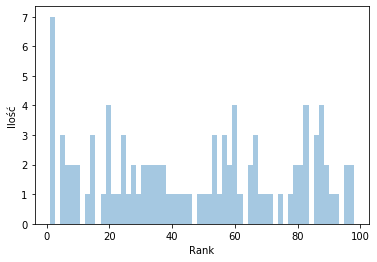

In [13]:
sns.distplot(ranks, bins=60, kde=False)
plt.xlabel('Rank')
plt.ylabel('Ilość')